# 5300 Final Project

Create classes to solve the double pendlum problem and the two-body problem for gravitational attraction.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt

## The Equation of Motion for a Double Pendulum
We start with Taylor equations (11.37) and (11.38):

$\begin{align}
  U = & (m_1 + m _2) g L_1 (1 - \cos \phi_1)  
  + m_2 g L_2 (1-\cos \phi_2)
\end{align}$

$\begin{align}
   T = & \frac{1}{2} (m_1 + m _2) L_1^2 \dot \phi_1^2 +
   + m_2 L_1 L_2 \dot \phi_1 \dot \phi_2 \cos (\phi_1 - \phi_2)
   \frac{1}{2} m_2 L_2^2 \dot \phi_2^2
\end{align}$

$\begin{align}
  L = & \frac{1}{2} (m_1 + m _2) L_1^2 \dot \phi_1^2
  + m_2 L_1 L_2 \dot \phi_1 \dot \phi_2 \cos (\phi_1 - \phi_2) \\
  & + \frac{1}{2} m_2 L_2^2 \dot \phi_2^2 - (m_1 + m _2) g L_1 (1 - \cos \phi_1) \\& - m_2 g L_2 (1-\cos \phi_2)
\end{align}$


Applying E-L Equations we get the equations of motion for $\phi_1$ and $\phi_2$ to be:

$\begin{align}
    (m_1 + m _2) L_1 \ddot \phi_1  + m_2 L_2 \ddot \phi_2 \cos (\phi_1 - \phi2) =
    - m_2 L_2 \dot \phi_2^2 \sin (\phi_1 - \phi_2) - (m_1 + m_2) g \sin \phi_1
\end{align}$

$\begin{align}
    L_2 \ddot \phi_2 + L_1 \ddot \phi_1 \cos (\phi_1 - \phi_2) = 
    L_1 \dot \phi_1^2 \sin (\phi_1 - \phi_2) - g \sin (\phi_2)
\end{align}$

Dividing the first by $(m_1 + m_2) L_1$ and the second by \$L_2$ and going to matrix form we get:

$
\begin{align}
\left(\begin{array}{c}
         \ddot \phi_1 \\
         \ddot \phi_2
\end{array}
\right)\begin{pmatrix}
        1 & \frac{m_2}{m_1 + m_2} \frac{L_2}{L_1} \cos (\phi_1 - \phi_2) \\
        \frac{L_1}{L_2} \cos (\phi_1 - \phi_2) & 1
        \end{pmatrix} =
        \left(\begin{array}{c}
         -\frac{m2}{m_1+m_2} \frac{L_2}{L_1} \dot \phi_2^2 \sin (\phi_1 - \phi_2) - \frac{g}{L_1} \sin \phi_1\\
         \frac{L_1}{L_2} \dot \phi_1^2 \sin (\phi_1 - \phi_2) - \frac{g}{L_2} \sin \phi_2
\end{array}\right)
\end{align}
$

Let's let:

$
\begin{align}
b = \frac{m_2}{m_1 + m_2} \frac{L_2}{L_1} \cos (\phi_1 - \phi_2)
\end{align}
$

$
\begin{align}
c = \frac{L_1}{L_2} \cos (\phi_1 - \phi_2)
\end{align}
$

Inverting the matrix on the left side we get:

$
\begin{align}
\left(\begin{array}{c}
         \ddot \phi_1 \\
         \ddot \phi_2
\end{array}\right) = \frac{1}{1-bc}
        \begin{pmatrix}
        1 & -b \\
        -c & 1
        \end{pmatrix}
        \left(\begin{array}{c}
         -\frac{m2}{m_1+m_2} \frac{L_2}{L_1} \dot \phi_2^2 \sin (\phi_1 - \phi_2) - \frac{g}{L_1} \sin \phi_1\\
         \frac{L_1}{L_2} \dot \phi_1^2 \sin (\phi_1 - \phi_2) - \frac{g}{L_2} \sin \phi_2
\end{array}\right)
\end{align}
$

To again simplify the equtions, let:

$
\begin{align}
H = -\frac{m2}{m_1+m_2} \frac{L_2}{L_1} \dot \phi_2^2 \sin (\phi_1 - \phi_2) - \frac{g}{L_1} \sin \phi_1
\end{align}
$

$
\begin{align}
D =  \frac{L_1}{L_2} \dot \phi_1^2 \sin (\phi_1 - \phi_2) - \frac{g}{L_2} \sin \phi_2
\end{align}
$

Then:

$
\begin{align}
\left(\begin{array}{c}
         \ddot \phi_1 \\
         \ddot \phi_2
\end{array}\right) = \frac{1}{1-bc}
        \left(\begin{array}{c}
         H - bD\\
         -cH + D
\end{array}\right)
\end{align}
$

## Pendulum class and utility functions
Using the eqtion of motion we found, we set up the ODE:

$\begin{align}
  \frac{d}{dt} \left(\begin{array}{c}
                     \phi_1 \\
                     \phi_2 \\
                     \dot \phi_1 \\
                     \dot \phi_2
               \end{array}\right) = 
                                    \left(\begin{array}{c}
                                          \dot \phi_1 \\
                                          \dot \phi_2 \\
                                          \frac{1}{1-bc} (f - bg) \\
                                          \frac{1}{1-bc} (-cf + g)
                                     \end{array}\right)
\end{align}
$

In [3]:
class DoublePendulum():
    """
    DoublePendulum class implements the parameters and differential equation for 
     a double pendulum using the notation from Taylor.
     
    Parameters
    ----------
    m1 : float
        mass of mass 1 
    m2 : float
        mass of mass 2
    L1 : float
        length of pendulum 1
    L2 : float
        length of pendulum 2 
    g : float
        acceleration due to gravity 

    Methods
    -------
    dy_dt(y, t)
        Returns the right side of the differential equation in vector y, 
        given time t and the corresponding value of y.
    """
    def __init__(self, m1, m2, L1, L2, g = 9.8):
        self.m1 = m1
        self.m2 = m2
        self.L1 = L1
        self.L2 = L2
        self.g = g
    
    def dy_dt(self, t, y):
        """
        This function returns the right-hand side of the diffeq: 
        [dphi1/dt dphi2/dt d^2phi1/dt^2  d^2phi2/dt^2]
        
        Parameters
        ----------
        t : float
            time 
        y : float
            A 4-component vector with y[0] = phi_1(t), y[1] = phi_2(t), y[2] = dphi_1/dt, y[3] = dphi_2/dt             
        """
        b = self.m2 / (self.m1 + self.m2) * self.L2/self.L1 * np.cos(y[0]-y[1])
        c = self.L1 / self.L2 * np.cos(y[0] - y[1])
        prefactor = 1 / (1 - b * c)
        H = - self.m2 / (self.m1 + self.m2) * self.L2/self.L1 * y[3]**2 * np.sin(y[0] - y[1]) \
            -self.g/self.L1 * np.sin(y[0])
        D = self.L1/self.L2 * y[2]**2 * np.sin(y[0] - y[1]) - self.g/self.L2 * np.sin(y[1])
        return [y[2],y[3], prefactor * (H - b * D), prefactor * (-c * H + D)]
    
    def solve_ode(self, t_pts, phi_1_0, phi_dot_1_0, phi_2_0, phi_dot_2_0, 
                  abserr=1.0e-8, relerr=1.0e-6):
        """
        Solve the ODE given initial conditions.
        For now use odeint, but we have the option to switch.
        Specify smaller abserr and relerr to get more precision.
        """
        y = [phi_1_0, phi_2_0, phi_dot_1_0, phi_dot_2_0] 
        solution = solve_ivp(self.dy_dt, (t_pts[0], t_pts[-1]), 
                             y, t_eval=t_pts, 
                             atol=abserr, rtol=relerr)
        phi_1, phi_2, phi_dot_1, phi_dot_2 = solution.y

        return phi_1, phi_2, phi_dot_1, phi_dot_2

In [4]:
def plot_y_vs_x(x, y, axis_labels=None, label=None, title=None, 
                color=None, linestyle=None, semilogy=False, loglog=False,
                ax=None):
    """
    Generic plotting function: return a figure axis with a plot of y vs. x,
    with line color and style, title, axis labels, and line label
    """
    if ax is None:        # if the axis object doesn't exist, make one
        ax = plt.gca()

    if (semilogy):
        line, = ax.semilogy(x, y, label=label, 
                            color=color, linestyle=linestyle)
    elif (loglog):
        line, = ax.loglog(x, y, label=label, 
                          color=color, linestyle=linestyle)
    else:
        line, = ax.plot(x, y, label=label, 
                    color=color, linestyle=linestyle)

    if label is not None:    # if a label if passed, show the legend
        ax.legend()
    if title is not None:    # set a title if one if passed
        ax.set_title(title)
    if axis_labels is not None:  # set x-axis and y-axis labels if passed  
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])

    return ax, line

In [5]:
def start_stop_indices(t_pts, plot_start, plot_stop):
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

## Make plots for the double pendulum

We'll set it up with the specified parameters.

In [6]:
# Labels for individual plot axes
phi_1_vs_time_labels = (r'$t$', r'$\phi_1(t)$')
phi_2_vs_time_labels = (r'$t$', r'$\phi_2(t)$')

# Plotting time (generate the full time then use slices)
t_start = 0.
t_end = 100.
delta_t = 0.01

t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

# Pendulum parameters
L1 = 1.
L2 = 1.
m1 = 1.
m2 = 1.
g = 9.8

# Instantiate a double pendulum 
p1 = DoublePendulum(m1 = m1, m2 = m2, L1 = L1, L2 = L2, g = g)

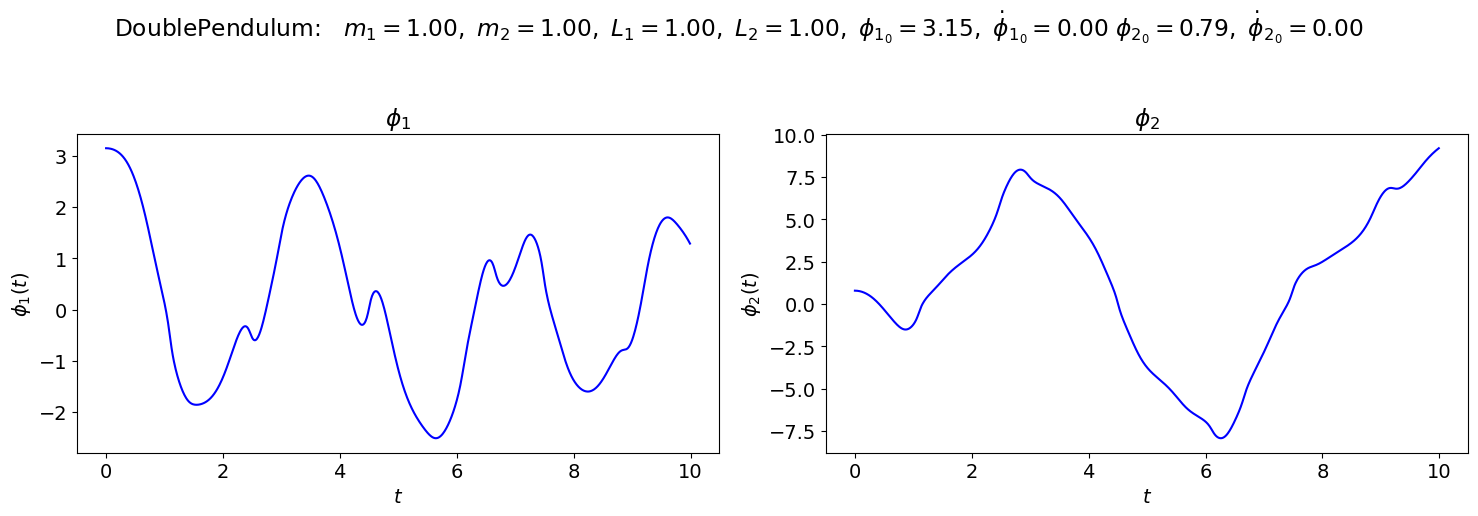

In [7]:
# initial conditions specified
phi_1_0 = np.pi + 0.01
phi_dot_1_0 = 0.0
phi_2_0 = np.pi / 4.
phi_dot_2_0 = 0.0

# solve the pendulum
phi_1, phi_2, phi_dot_1, phi_dot_2 = p1.solve_ode(t_pts, phi_1_0, phi_dot_1_0, phi_2_0, phi_dot_2_0)

# Change the common font size
font_size = 14
plt.rcParams.update({'font.size': font_size})

# start the plot!
fig = plt.figure(figsize=(15,5))
overall_title = 'DoublePendulum:  ' + \
                rf' $m_1 = {m1:.2f},$' + \
                rf' $m_2 = {m2:.2f},$' + \
                rf' $L_1 = {L1:.2f},$' + \
                rf' $L_2 = {L2:.2f},$' + \
                rf' $\phi_{{1_0}} = {phi_1_0:.2f},$' + \
                rf' $\dot\phi_{{1_0}} = {phi_dot_1_0:.2f}$' + \
                rf' $\phi_{{2_0}} = {phi_2_0:.2f},$' + \
                rf' $\dot\phi_{{2_0}} = {phi_dot_2_0:.2f}$'
fig.suptitle(overall_title, va='baseline')
    
# first plot: plot phi_1 from t=0 to t=10   
ax_a = fig.add_subplot(1,2,1)                  

start, stop = start_stop_indices(t_pts, 0., 10.)    
plot_y_vs_x(t_pts[start : stop], phi_1[start : stop], 
            axis_labels=phi_1_vs_time_labels, 
            color='blue',
            label=None, 
            title=rf'$\phi_1$', 
            ax=ax_a)    
                              
# second plot: plot  phi_2 from t=0 to t=10   
ax_b = fig.add_subplot(1,2,2)                  

start, stop = start_stop_indices(t_pts, 0., 10.)    
plot_y_vs_x(t_pts[start : stop], phi_2[start : stop], 
            axis_labels=phi_2_vs_time_labels, 
            color='blue',
            label=None, 
            title=rf'$\phi_2$', 
            ax=ax_b)     

fig.tight_layout()

## Chaos Check
To show the system is chaotic, we make plots of $\Delta \phi$ for double pendulums of slightly different intial conditions for both $\phi_1$ and $\phi_2$ and see if they have a positive slope

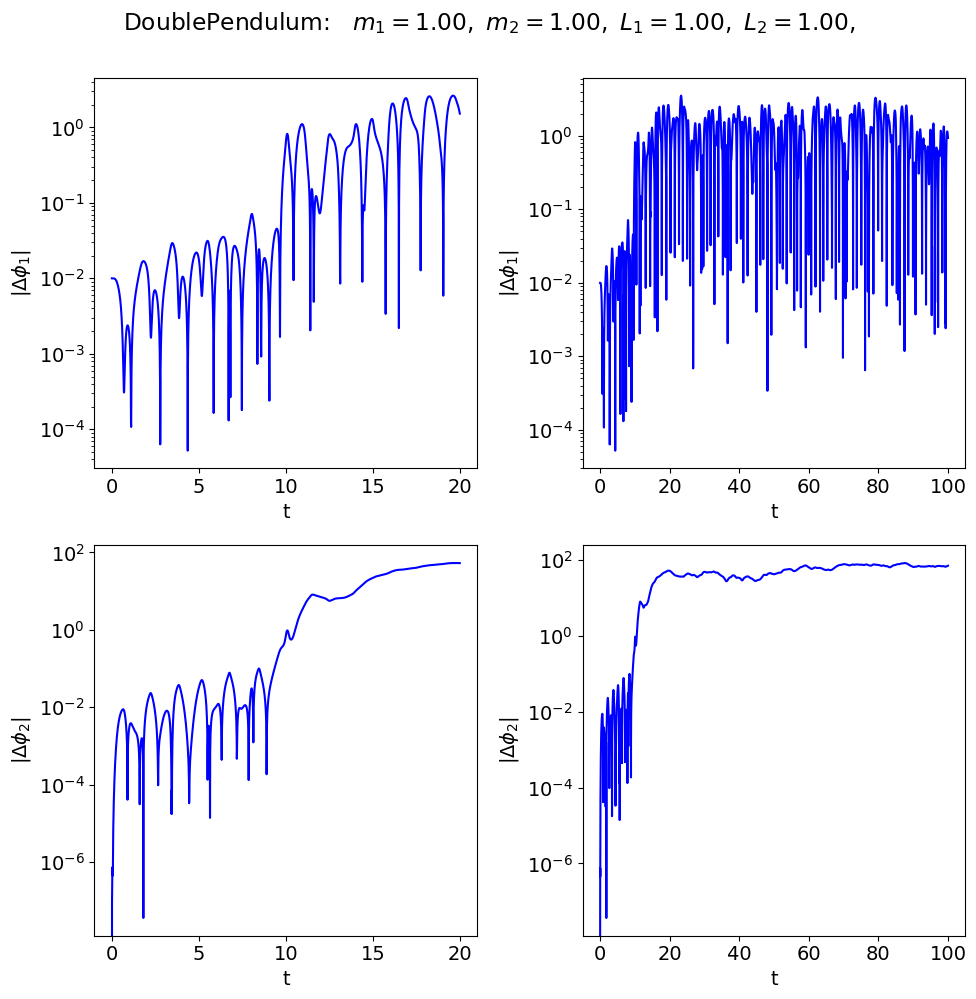

In [8]:
# Labels for individual plot axes
Delta_phi_1_vs_time_labels = (r'$t$', r'$\Delta\phi_1(t)$')
Delta_phi_2_vs_time_labels = (r'$t$', r'$\Delta\phi_2(t)$')

# Common plotting time (generate the full time then use slices)
t_start = 0.
t_end = 100.
delta_t = 0.01

t_pts = np.arange(t_start, t_end+delta_t, delta_t)

# make a plot of Delta phi for same double pendulum but two different initial conds
phi_1i_0 = np.pi / 2.
phi_dot_1i_0 = 0.0
phi_2i_0 = np.pi / 2.
phi_dot_2i_0 = 0.0
phi_1i, phi_2i, phi_dot_1i, phi_dot_2i = p1.solve_ode(t_pts, phi_1i_0, phi_dot_1i_0, phi_2i_0, phi_dot_2i_0)

phi_1j_0 = np.pi/2. + 0.01 # 0.01 radians higher
phi_dot_1j_0 = 0.0
phi_2j_0 = np.pi / 2.
phi_dot_2j_0 = 0.0
phi_1j, phi_2j, phi_dot_1j, phi_dot_2j = p1.solve_ode(t_pts, phi_1j_0, phi_dot_1j_0, phi_2j_0, phi_dot_2j_0)

# Calculate the absolute value of \phi_1j - \phi_1i
Delta_phi_1 = np.fabs(phi_1j - phi_1i)

# Calculate the absolute value of \phi_2j - \phi_2i
Delta_phi_2 = np.fabs(phi_2j - phi_2i)

# Change the common font size
font_size = 14
plt.rcParams.update({'font.size': font_size})

# start the plot!
fig = plt.figure(figsize=(10,10))
overall_title = 'DoublePendulum:  ' + \
                rf' $m_1 = {m1:.2f},$' + \
                rf' $m_2 = {m2:.2f},$' + \
                rf' $L_1 = {L1:.2f},$' + \
                rf' $L_2 = {L2:.2f},$'
fig.suptitle(overall_title, va='baseline')

# Four plots: plot from t=0 to t=20 and another from t=0 to t=100 for both phi_1 and phi_2
ax_a = fig.add_subplot(2,2,1)                  

start, stop = start_stop_indices(t_pts, 0., 20.)
ax_a.semilogy(t_pts[start : stop], Delta_phi_1[start : stop], 
            color='blue', label=None)    
ax_a.set_xlabel('t')
ax_a.set_ylabel(r'$|\Delta\phi_1|$')

ax_b = fig.add_subplot(2,2,2)                  

start, stop = start_stop_indices(t_pts, 0., 100.)
plot_y_vs_x(t_pts[start : stop], Delta_phi_1[start : stop], 
            color='blue', label=None, semilogy=True)    
ax_b.set_xlabel('t')
ax_b.set_ylabel(r'$|\Delta\phi_1|$')

ax_c = fig.add_subplot(2,2,3)                  

start, stop = start_stop_indices(t_pts, 0., 20.)
plot_y_vs_x(t_pts[start : stop], Delta_phi_2[start : stop], 
            color='blue', label=None, semilogy=True)    
ax_c.set_xlabel('t')
ax_c.set_ylabel(r'$|\Delta\phi_2|$')

ax_d = fig.add_subplot(2,2,4)                  

start, stop = start_stop_indices(t_pts, 0., 100.)
plot_y_vs_x(t_pts[start : stop], Delta_phi_2[start : stop], 
            color='blue', label=None, semilogy=True)    
ax_d.set_xlabel('t')
ax_d.set_ylabel(r'$|\Delta\phi_2|$')
                              
fig.tight_layout()

We see that there is a positive slope for both diagrams, suggesting a positive Liapunov exponent, indicating chaotic motion.

## Animating the Double Pendulum

In [ ]:
from matplotlib import animation, rc
from IPython.display import HTML

t_start = 0.
t_end = 100.
delta_t = 0.01

t_pts = np.arange(t_start, t_end+delta_t, delta_t) 

# start a pendulum
# Pendulum parameters
L1 = 1.
L2 = 1.
m1 = 1.
m2 = 1.
g = 9.8

# Instantiate a double pendulum 
p2 = DoublePendulum(m1 = m1, m2 = m2, L1 = L1, L2 = L2, g = g)

# initial conditions specified
phi_1_0 = np.pi 
phi_dot_1_0 = 0.0
phi_2_0 = np.pi / 4.
phi_dot_2_0 = 0.0

# solve the pendulum
phi_1, phi_2, phi_dot_1, phi_dot_2 = p2.solve_ode(t_pts, phi_1_0, phi_dot_1_0, phi_2_0, phi_dot_2_0)

    
#get x and y coordinates for any time
x_1, y_1 = L1 * np.sin(phi_1), -L1 * np.cos(phi_1)
x_2, y_2 = x_1 + L2 * np.sin(phi_2), y_1 - L2 * np.cos(phi_2)


#intial coordiantes
x_1_0, y_1_0 = L1 * np.sin(phi_1_0), -L1 * np.cos(phi_1_0)
x_2_0, y_2_0 = x_1_0 + L2 * np.sin(phi_2_0), y_1_0 - L2 * np.cos(phi_2_0)

#make intial pendulum massess and rods
fig = plt.figure(figsize=(6,6), num='Double Pendulum')
ax = fig.add_subplot(1,1,1)
gap = 0.1
ax.set_xlim(-(L1+L2)-gap, (L1+L2)+gap)
ax.set_ylim(-(L1+L2)-gap, (L1+L2)+gap)
line1, = ax.plot([0, x_1_0], [0, y_1_0], lw=3, c='k')
mass_radius = 0.08
circle1 = ax.add_patch(plt.Circle([x_1_0,y_1_0], mass_radius,
                      fc='r', zorder=3))
line2, = ax.plot([x_1_0, x_2_0], [y_1_0, y_2_0], lw=3, c='k')
circle2 = ax.add_patch(plt.Circle([x_2_0,y_2_0], mass_radius,
                      fc='r', zorder=3))
fig.tight_layout()

In [ ]:
%%capture

fig_anim = plt.figure(figsize=(6,6), num='Double Pendulum')
ax_anim = fig_anim.add_subplot(1,1,1)
gap = 0.1
ax_anim.set_xlim(-(L1+L2)-gap, (L1+L2)+gap)
ax_anim.set_ylim(-(L1+L2)-gap, (L1+L2)+gap)

# By assigning the first return from plot all parts of the pendulum
#, we can later change the values in the line.
line_anim1, = ax_anim.plot([0, x_1_0], [0, y_1_0], lw=3, c='k')
mass_radius = 0.08
circle_anim1 = ax_anim.add_patch(plt.Circle([x_1_0,y_1_0], mass_radius,
                      fc='r', zorder=3))
line_anim2, = ax_anim.plot([x_1_0, x_2_0], [y_1_0, y_2_0], lw=3, c='k')
circle_anim2 = ax_anim.add_patch(plt.Circle([x_2_0,y_2_0], mass_radius,
                      fc='r', zorder=3))

fig_anim.tight_layout()

In [ ]:
def animate_pendulum(i):
    """This is the function called by FuncAnimation to create each frame,
        numbered by i.  So each i corresponds to a point in the t_pts
        array, with index i.
    """
    t = t_pts[i]
    x_1_i, y_1_i = x_1[i], y_1[i]
    x_2_i, y_2_i = x_2[i], y_2[i]

    # overwrite lines and circles with new points
    line_anim1.set_data([0, x_1_i], [0, y_1_i])
    circle_anim1.set_center([x_1_i,y_1_i])
    line_anim2.set_data([x_1_i, x_2_i], [y_1_i, y_2_i])
    circle_anim2.set_center([x_2_i,y_2_i])
    
    return (line_anim1,circle_anim1,line_anim2, circle_anim2)   # this is needed for blit=True to work

In [ ]:
iiframe_interval = 40.  # time between frames
frame_number = 500    # number of frames to include (index of t_pts)
anim = animation.FuncAnimation(fig_anim, 
                               animate_pendulum, 
                               init_func=None,
                               frames=frame_number, 
                               interval=frame_interval, 
                               blit=True,
                               repeat=False)

In [ ]:
HTML(anim.to_jshtml())

## Gravitational Orbits in Cartesian Coordinates
To plot these orbits, we first must find the equations of motion in Cartesian coordinates.

We start by writing down the Lagrangian for two mass $m_1$ and $m_2$:

$\begin{align}
  U = & - \frac{G m_1 m_2}{\sqrt{(x_1 - x_2 )^2 + (y_1 - y_2)^2 + (z_1 - z_2)^2}}
\end{align}$

$\begin{align}
  T =& \frac{1}{2} m_1 (\dot x_1^2 + \dot y_1^2 + \dot z_1^2) + \frac{1}{2} m_2 (\dot x_2^2 + \dot y_2^2 + \dot z_2^2)
\end{align}$

$\begin{align}
  L = & \frac{1}{2} m_1 (\dot x_1^2 + \dot y_1^2 + \dot z_1^2) + \frac{1}{2} m_2 (\dot x_2^2 + \dot y_2^2 + 
  \dot z_2^2) \\ & + \frac{G m_1 m_2}{\sqrt{(x_1 - x_2 )^2 + (y_1 - y_2)^2 + (z_1 - z_2)^2}}
\end{align}$

Now we apply E-L equations for each coordinate. Note that there is a symmetry between the the x,y,and z coordinates. Let's focus on the x coodinate for both mass 1 and 2 for now.

For the x coordinates, E-L equations tell us:

$\begin{align}
  m_1 \ddot x_1 = \frac{-G m_1 m_2 (x_1 - x_2)}{((x_1 - x_2)^2 + (y_1 - y_2)^2 + (z_1 - z_2)^2)^\frac{3}{2}}
\end{align}$

$\begin{align}
  m_2 \ddot x_2 = \frac{G m_1 m_2 (x_1 - x_2)}{((x_1 - x_2)^2 + (y_1 - y_2)^2 + (z_1 - z_2)^2)^\frac{3}{2}}
\end{align}$

Moving to a matrix form and using the symmetry to get the other components and letting:

$\begin{align}
  B = \frac{G m_1 m_2}{((x_1 - x_2)^2 + (y_1 - y_2)^2 + (z_1 - z_2)^2)^\frac{3}{2}}
\end{align}$

We get:

$
\begin{align}
\left(\begin{array}{c}
         \ddot x_1 \\
         \ddot x_2 \\
         \ddot y_1 \\
         \ddot y_2 \\
         \ddot z_1 \\
         \ddot z_2
\end{array}\right) = B
        \left(\begin{array}{c}
         \frac{-(x_1-x_2)}{m_1}\\
         \frac{(x_1-x_2)}{m_2} \\
         \frac{-(y_1-y_2)}{m_1}\\
         \frac{(y_1-y_2)}{m_2} \\
         \frac{-(z_1-z_2)}{m_1} \\
         \frac{(z_1-z_2)}{m_2}
\end{array}\right)
\end{align}
$

for the equations of motion

## Orbit class and utility functions
Using the eqtion of motion we found, we set up the ODE:

$\begin{align}
  \frac{d}{dt} \left(\begin{array}{c}
                     x_1 \\
                     x_2 \\
                     y_1 \\
                     y_2 \\
                     z_1 \\
                     z_2 \\
                     \dot x_1 \\
                     \dot x_2 \\
                     \dot y_1 \\
                     \dot y_2 \\
                     \dot z_1 \\
                     \dot z_2
               \end{array}\right) = 
                                    \left(\begin{array}{c}
                                    \dot x_1 \\
                                    \dot x_2 \\
                                    \dot y_1 \\
                                    \dot y_2 \\
                                    \dot z_1 \\
                                    \dot z_2 \\
                                    \frac{-B(x_1-x_2)}{m_1} \\
                                    \frac{B(x_1-x_2)}{m_2} \\
                                    \frac{-B(y_1-y_2)}{m_1} \\
                                    \frac{B(y_1-y_2)}{m_2} \\
                                    \frac{-B(z_1-z_2)}{m_1} \\
                                    \frac{B(z_1-z_2)}{m_2}
                                     \end{array}\right)
\end{align}
$

In [9]:
class CartesianOrbit():
    """
    CartesianOrbit class implements the parameters and differential equation for 
     the orbit of two bodies using Cartesian Coordinates.
     
    Parameters
    ----------
    m1 : float
        mass of body 1 
    m2 : float
        mass of body 2
    G : float
        gravitational constant

    Methods
    -------
    dr_dt(y, t)
        Returns the right side of the differential equation in vector r, 
        given time t and the corresponding value of r.
    """
    def __init__(self, m1, m2, G = 6.67 * (10**-11)):
        self.m1 = m1
        self.m2 = m2
        self.G = G
    
    def dr_dt(self, t, r):
        """
        This function returns the right-hand side of the diffeq: 
        [dx1/dt dx2/dt ... d^2z1/dt^2  d^2z2/dt^2]
        
        Parameters
        ----------
        t : float
            time 
        r : float
            A 12-component vector with r[0] = x_1(t), r[1] = x_2(t), r[2] = y_1(t), r[3] = y_2(t)
            r[4] = z_1(t), r[5] = z_2(t), r[6] = dx_1/dt, ... , r[11] = dz_2/dt
        """
        B = self.G * self.m1 * self.m2 / ((r[0]-r[1])**2 + (r[2]-r[3])**2 + (r[4]-r[5])**2)**(3./2.)
        
        return [r[6],r[7],r[8],r[9],r[10],r[11], -(B/self.m1)*(r[0]-r[1]), (B/self.m2)*(r[0]-r[1]),
               -(B/self.m1)*(r[2]-r[3]), (B/self.m2)*(r[2]-r[3]),
                -(B/self.m1) * (r[4]-r[5]), (B/self.m2)*(r[4]-r[5])]
    
    def solve_ode(self, t_pts, x_1_0, x_2_0, y_1_0, y_2_0, z_1_0, z_2_0,
             x_dot_1_0, x_dot_2_0, y_dot_1_0, y_dot_2_0, z_dot_1_0, z_dot_2_0, 
                  abserr=1.0e-8, relerr=1.0e-6):
        """
        Solve the ODE given initial conditions.
        For now use odeint, but we have the option to switch.
        Specify smaller abserr and relerr to get more precision.
        """
        y = [x_1_0, x_2_0, y_1_0, y_2_0, z_1_0, z_2_0,
             x_dot_1_0, x_dot_2_0, y_dot_1_0, y_dot_2_0, z_dot_1_0, z_dot_2_0] 
        solution = solve_ivp(self.dr_dt, (t_pts[0], t_pts[-1]), 
                             y, t_eval=t_pts, 
                             atol=abserr, rtol=relerr)
        x_1, x_2, y_1, y_2, z_1, z_2, x_dot_1, x_dot_2, y_dot_1, y_dot_2, z_dot_1, z_dot_2 = solution.y

        return x_1, x_2, y_1, y_2, z_1, z_2, x_dot_1, x_dot_2, y_dot_1, y_dot_2, z_dot_1, z_dot_2

In [10]:
def plot_y_vs_x(x, y, axis_labels=None, label=None, title=None, 
                color=None, linestyle=None, semilogy=False, loglog=False,
                ax=None):
    """
    Generic plotting function: return a figure axis with a plot of y vs. x,
    with line color and style, title, axis labels, and line label
    """
    if ax is None:        # if the axis object doesn't exist, make one
        ax = plt.gca()

    if (semilogy):
        line, = ax.semilogy(x, y, label=label, 
                            color=color, linestyle=linestyle)
    elif (loglog):
        line, = ax.loglog(x, y, label=label, 
                          color=color, linestyle=linestyle)
    else:
        line, = ax.plot(x, y, label=label, 
                    color=color, linestyle=linestyle)

    if label is not None:    # if a label if passed, show the legend
        ax.legend()
    if title is not None:    # set a title if one if passed
        ax.set_title(title)
    if axis_labels is not None:  # set x-axis and y-axis labels if passed  
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])

    return ax, line

In [11]:
def start_stop_indices(t_pts, plot_start, plot_stop):
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

## Make plots for the orbits

We'll set it up with the specified parameters. Let's allow only for orbits in the x-y plane. That is to say $z_{{1_0}} = z_{{2_0}} = \dot z_{{1_0}} = \dot z_{{2_0}} = 0$. The intial z coordinate can be done without loss of generality, as we are just rotating our axis until both masses are in the x-y plane

In [12]:
y_vs_x_labels = (r'$x$', r'$y$')

# Plotting time (generate the full time then use slices)
t_start = 0.
t_end = 100.
delta_t = 0.01

t_pts = np.arange(t_start, t_end+delta_t, delta_t)

# Choosing parameters
m1 = 1.
m2 = 1.
G = 10.

# Instantiate an orbit 
o1 = CartesianOrbit(m1 = m1, m2 = m2, G = G)

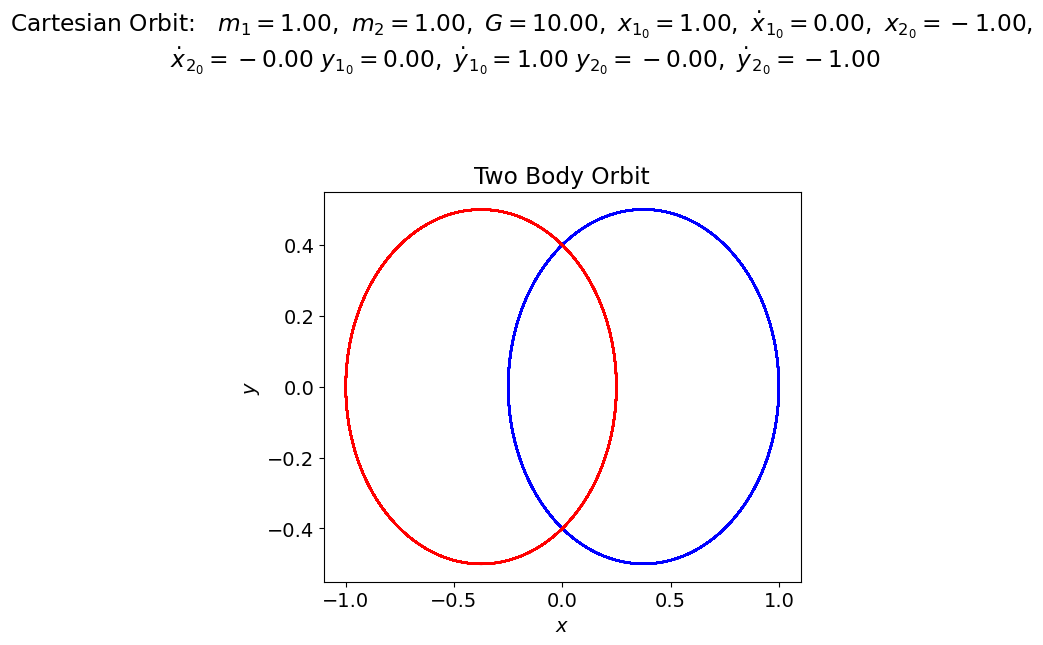

In [13]:
# initial conditions specified
x_1_0,x_dot_1_0 = 1., 0.
x_2_0, x_dot_2_0 = -(m1/m2) * x_1_0, -(m1/m2) * x_dot_1_0

y_1_0, y_dot_1_0 = 0., 1.
y_2_0, y_dot_2_0 = -(m1/m2) * y_1_0, -(m1/m2) * y_dot_1_0

z_1_0 = 0.0
z_dot_1_0 = 0.0
z_2_0 = 0.0
z_dot_2_0 = 0.0

# solve the orbit
(x_1, x_2, y_1, y_2, z_1, z_2, x_dot_1, x_dot_2, y_dot_1,
 y_dot_2, z_dot_1, z_dot_2) = o1.solve_ode(t_pts, x_1_0, x_2_0, y_1_0, y_2_0, z_1_0, z_2_0,
                                                           x_dot_1_0, x_dot_2_0, y_dot_1_0, y_dot_2_0, z_dot_1_0,
                                                           z_dot_2_0)

# Change the common font size
font_size = 14
plt.rcParams.update({'font.size': font_size})

# start the plot!
fig = plt.figure(figsize=(6,6))
overall_title = 'Cartesian Orbit:  ' + \
                 rf' $m_1 = {m1:.2f},$' + \
                 rf' $m_2 = {m2:.2f},$' + \
                 rf' $G = {G:.2f},$' + \
                 rf' $x_{{1_0}} = {x_1_0:.2f},$' + \
                 rf' $\dot x_{{1_0}} = {x_dot_1_0:.2f},$' + \
                 rf' $x_{{2_0}} = {x_2_0:.2f},$' + '\n' + \
                 rf' $\dot x_{{2_0}} = {x_dot_2_0:.2f}$' + \
                 rf' $y_{{1_0}} = {y_1_0:.2f},$' + \
                 rf' $\dot y_{{1_0}} = {y_dot_1_0:.2f}$' + \
                 rf' $y_{{2_0}} = {y_2_0:.2f},$' + \
                 rf' $\dot y_{{2_0}} = {y_dot_2_0:.2f}$' 
# #                '\n'     # \n means a new line (adds some space here)
fig.suptitle(overall_title, va='baseline')
    
# first plot: plot from t=0 to t=100  
ax_a = fig.add_subplot(1,1,1)                  

start, stop = start_stop_indices(t_pts, 0., 100.)    
plot_y_vs_x(x_1[start : stop], y_1[start : stop], 
            axis_labels=y_vs_x_labels, 
            color='blue',
            label=None, 
            title=rf'', 
            ax=ax_a)
plot_y_vs_x(x_2[start : stop], y_2[start : stop], 
            axis_labels=y_vs_x_labels, 
            color='red',
            label=None, 
            title=rf'Two Body Orbit',
            ax=ax_a)
fig.tight_layout()

## Now Let's make $M_1 >> M_2$

In [14]:
y_vs_x_labels = (r'$x$', r'$y$')

# Plotting time
t_start = 0.
t_end = 200.
delta_t = 0.01

t_pts = np.arange(t_start, t_end+delta_t, delta_t)

# Choosing parameters
m1 = 300.
m2 = 1.
G = 5. * 10**4

# Instantiate an orbit 
o2 = CartesianOrbit(m1 = m1, m2 = m2, G = G)

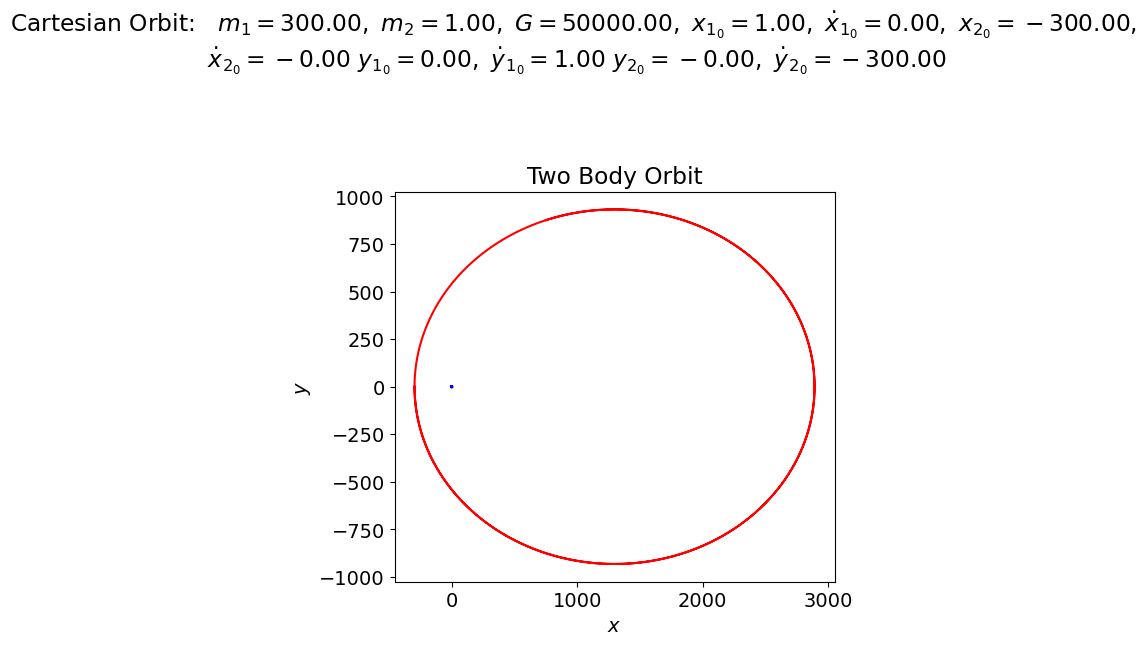

In [15]:
# initial conditions specified
x_1_0,x_dot_1_0 = 1., 0.
x_2_0, x_dot_2_0 = -(m1/m2) * x_1_0, -(m1/m2) * x_dot_1_0

y_1_0, y_dot_1_0 = 0., 1.
y_2_0, y_dot_2_0 = -(m1/m2) * y_1_0, -(m1/m2) * y_dot_1_0

z_1_0 = 0.0
z_dot_1_0 = 0.0
z_2_0 = 0.0
z_dot_2_0 = 0.0

# solve the orbit
(x_1, x_2, y_1, y_2, z_1, z_2, x_dot_1, x_dot_2, y_dot_1,
 y_dot_2, z_dot_1, z_dot_2) = o2.solve_ode(t_pts, x_1_0, x_2_0, y_1_0, y_2_0, z_1_0, z_2_0,
                                                           x_dot_1_0, x_dot_2_0, y_dot_1_0, y_dot_2_0, z_dot_1_0,
                                                           z_dot_2_0)

# Change the common font size
font_size = 14
plt.rcParams.update({'font.size': font_size})

# start the plot!
fig = plt.figure(figsize=(6,6))
overall_title = 'Cartesian Orbit:  ' + \
                 rf' $m_1 = {m1:.2f},$' + \
                 rf' $m_2 = {m2:.2f},$' + \
                 rf' $G = {G:.2f},$' + \
                 rf' $x_{{1_0}} = {x_1_0:.2f},$' + \
                 rf' $\dot x_{{1_0}} = {x_dot_1_0:.2f},$' + \
                 rf' $x_{{2_0}} = {x_2_0:.2f},$' + '\n' + \
                 rf' $\dot x_{{2_0}} = {x_dot_2_0:.2f}$' + \
                 rf' $y_{{1_0}} = {y_1_0:.2f},$' + \
                 rf' $\dot y_{{1_0}} = {y_dot_1_0:.2f}$' + \
                 rf' $y_{{2_0}} = {y_2_0:.2f},$' + \
                 rf' $\dot y_{{2_0}} = {y_dot_2_0:.2f}$' 
# #                '\n'     # \n means a new line (adds some space here)
fig.suptitle(overall_title, va='baseline')
    
#plot from t=0 to t=200  
ax_a = fig.add_subplot(1,1,1)                  

start, stop = start_stop_indices(t_pts, 0., 200.)    
plot_y_vs_x(x_1[start : stop], y_1[start : stop], 
            axis_labels=y_vs_x_labels, 
            color='blue',
            label=None, 
            title=rf'', 
            ax=ax_a)
plot_y_vs_x(x_2[start : stop], y_2[start : stop], 
            axis_labels=y_vs_x_labels, 
            color='red',
            label=None, 
            title=rf'Two Body Orbit',
            ax=ax_a)
fig.tight_layout()

## Animating the Two-Body Orbit

In [ ]:
from matplotlib import animation, rc
from IPython.display import HTML

# initial conditions specified
x_1_0,x_dot_1_0 = 1., 0.
x_2_0, x_dot_2_0 = -(m1/m2) * x_1_0, -(m1/m2) * x_dot_1_0

y_1_0, y_dot_1_0 = 0., 1.
y_2_0, y_dot_2_0 = -(m1/m2) * y_1_0, -(m1/m2) * y_dot_1_0

z_1_0 = 0.0
z_dot_1_0 = 0.0
z_2_0 = 0.0
z_dot_2_0 = 0.0

t_start = 0.
t_end = 400.
delta_t = 5.

t_pts = np.arange(t_start, t_end+delta_t, delta_t)


(x_1, x_2, y_1, y_2, z_1, z_2, x_dot_1, x_dot_2, y_dot_1,
 y_dot_2, z_dot_1, z_dot_2) = o2.solve_ode(t_pts, x_1_0, x_2_0, y_1_0, y_2_0, z_1_0, z_2_0,
                                                           x_dot_1_0, x_dot_2_0, y_dot_1_0, y_dot_2_0, z_dot_1_0,
                                                           z_dot_2_0)


x_1_0, y_1_0 = x_1[0], y_1[0]
x_2_0, y_2_0 = x_2[0], y_2[0]

#make intial bodies
fig = plt.figure(figsize=(6,6), num='Two-Body Orbit')
ax = fig.add_subplot(1,1,1)
gap = 500
ax.set_xlim(min(y_2)-gap, max(x_2)+gap)
ax.set_ylim(min(y_2)-gap, max(x_2)+gap)
mass_radius1 = 100
mass_radius2 = 50
circle1 = ax.add_patch(plt.Circle([x_1_0,y_1_0], mass_radius1,
                      fc='b', zorder=3))
circle2 = ax.add_patch(plt.Circle([x_2_0,y_2_0], mass_radius2,
                      fc='r', zorder=3))
fig.tight_layout()

In [ ]:
%%capture

fig_anim = plt.figure(figsize=(6,6), num='Two-Body Orbit')
ax_anim = fig_anim.add_subplot(1,1,1)
gap = 500
ax_anim.set_xlim(min(y_2)-gap, max(x_2)+gap)
ax_anim.set_ylim(min(y_2)-gap, max(x_2)+gap)

# By assigning the first return from plot to line_anim, we can later change
#  the values in the line.
mass_radius1 = 100
mass_radius2 = 50
circle_anim1 = ax_anim.add_patch(plt.Circle([x_1_0,y_1_0], mass_radius1,
                      fc='b', zorder=3))
circle_anim2 = ax_anim.add_patch(plt.Circle([x_2_0,y_2_0], mass_radius2,
                      fc='r', zorder=3))

fig_anim.tight_layout()

In [ ]:
def animate_pendulum(i):
    """This is the function called by FuncAnimation to create each frame,
        numbered by i.  So each i corresponds to a point in the t_pts
        array, with index i.
    """
    t = t_pts[i]
    x_1_i, y_1_i = x_1[i], y_1[i]
    x_2_i, y_2_i = x_2[i], y_2[i]

    # overwrite lines and circles with new points
    circle_anim1.set_center([x_1_i,y_1_i])
    circle_anim2.set_center([x_2_i,y_2_i])
    
    return (circle_anim1, circle_anim2)   # this is needed for blit=True to work

In [ ]:
iiframe_interval = 10.  # time between frames
frame_number = 81  # number of frames to include (index of t_pts)
anim = animation.FuncAnimation(fig_anim, 
                               animate_pendulum, 
                               init_func=None,
                               frames=frame_number, 
                               interval=frame_interval, 
                               blit=True,
                               repeat=False)

In [ ]:
HTML(anim.to_jshtml())